# An introduction to random walks

Random walks are commonly used to model stochastic behaviour in statistical mechanics and mathematical finance. 

This notebook aims to learn about random walks and related processes by:
1. Simulating discrete random walks to understand their connection to Brownian motion and the Wiener process
2. Compute some statistical properties of the Ornstein-Uhlenbeck (OU) process
3. Explore the properties of geometric Brownian motion (GBM)

## 1. Random walks

### 1.1 Discrete symmetric random walk in 1D

Let us consider a walk on a one-dimensional path where each position on the path is labelled by an integer $m$. At each step along the path, there is an equal probability of moving left by one position left to $m-1$ or one right by position to $m+1$.

Let's simulate many random walks and look at the resulting distribution of positions after $n$ steps:

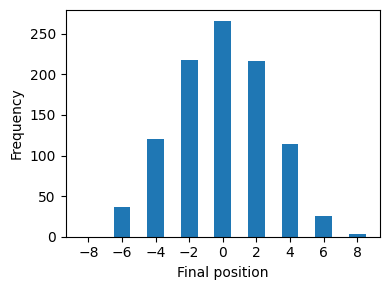

In [1]:
import numpy as np
import matplotlib.pyplot as plt

p = 1/2  # probability of moving left or right
n_steps = 8  # number of steps
n_walks = 1000  # number of walks

# Generate outcomes
starting_position = 0 
final_positions = np.zeros(n_walks)
for run in range(n_walks):
    flips = np.random.uniform(0, 1, n_steps) <= p # Generate a sequence of coin-flip results
    moves = 2 * flips - 1  # Compute the moves by shifting (`True`, `False`) to (`1`, `-1`)
    final_positions[run] = np.sum(moves) + starting_position

# Plot outcomes in a histogram
m_max = n_steps
n_bins = 2 * m_max + 1
fig, ax = plt.subplots(figsize=(4, 3),layout='tight')   
ax.hist(final_positions, bins=n_bins, range=(-m_max-0.5, m_max+0.5))
ax.set_xlabel('Final position')
ax.set_ylabel('Frequency')
ax.set_xticks(np.arange(-m_max, m_max+1, 2))
plt.show()

### 1.2 Solution of the discrete symmetric random walk

The symmetric random walk above can be described by a master equation
$$
P_m(n+1) = \frac{1}{2} P_{m-1}(n) + \frac{1}{2} P_{m+1}(n),
$$
where $P_m(n)$ is the probability of being in position $m$ after $n$ steps.

The master equation can be solved by multipliying both sides with the characteristic function 
$$G_n(k) = \sum_{m=-\infty}^{\infty}{e^{i k m} P_m(n)}, $$
leading to
$$G_{n+1}(k) = \cos(k) G_n(k).$$
Using $P_m(0) = \delta_{m,0}$, 
$$G_n(k) = \cos^n(k).$$
After some algebra using the binomial expansion
$$
G_n= \left( p + q \right)^n = \sum_{\ell=0}^{n} p^{n - \ell} q^{\ell} \frac{n!}{\ell! (n - \ell)!},
$$,
where $p = e^{ik} / 2$ and $q = e^{-ik} / 2$, we end up with
$$P_m(n) = \frac{1}{2^n} \frac{n!}{ \left( \frac{n - m}{2} \right)! \left( \frac{n+m}{2} \right)! }.$$

For large $n$ and $m << n$, we can use Stirling's formula $\log n! \approx n \log n - n$ to find
$$P_m(n) \propto \exp\left(-\frac{m^2}{2n}\right).$$
This is an example of the central limit theorem!

### 1.3 Statistical properties

## 2. The Ornstein-Uhlenbeck process

This notebook aims to explore the Ornstein-Uhlenbeck process, including, (a) some of its statistical properties, and (b) how to simulate it.

An Ornstein-Uhlenbeck process $x_t$ is defined by a stochastic differential equation (SDE) of the form
$$
dx_t = -\theta x_t dt + \sigma dW_t,
$$
where $\theta > 0$, $\sigma > 0$ are some parameters, $W_t$ denotes a Wiener process, and $t$ is a discrete index that typically represents the time-step.

The mean-reverting Ornstein-Uhlenbeck takes a similar form, 
$$
dx_t = \theta (\mu - x_t) dt + \sigma dW_t.
$$

Analysis of the mean-reverting Ornstein-Uhlenbeck process reveals that it has 
mean $$\mathbb{E}(x_t) = x_0 e^{-\theta t} + \mu (1 - e^{-\theta t})$$ 
and variance
$$\mathrm{Var}(x_t) = \frac{\sigma^2}{2 \theta} (1 - e^{-2 \theta t}).$$

### 2.1 Numerical Simulation

A forward Euler discretisation of the mean-reverting Ornstein-Uhlenbeck process leads to
$$
x_{t+dt} = x_t + \theta (\mu - x_t) dt + \sigma dW_t.
$$
To simulate the above equation numerically, we can draw $dW_t$ from a Gaussian distribution with mean zero and variance $dt$.

In [2]:
# Generate data from an Ornstein-Uhlenbeck (OU) process
import numpy as np

n_runs = 200
n_steps = 100

theta = 1.0
mu = 0.0
sigma = 1.0
x0 = 10.0

t_start = 0.0
t_final = 10 / theta
t = np.linspace(t_start, t_final, n_steps)

x = np.zeros((n_runs, n_steps))
x[:, 0] = x0

for run in range(n_runs):
    for i in range(n_steps - 1):
        dt = t[i+1] - t[i]
        v = np.random.normal() * np.sqrt(dt)
        x[run, i+1] = x[run, i] + theta * (mu - x[run, i]) * dt + sigma * v

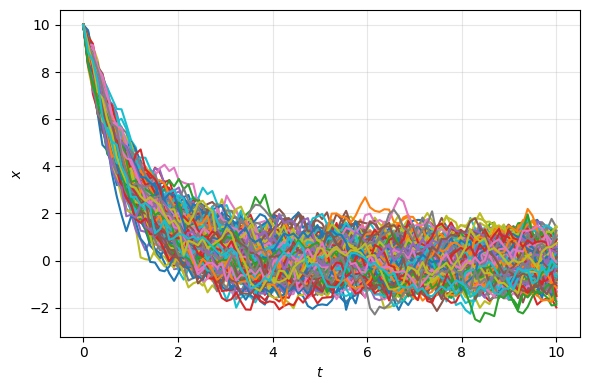

In [3]:
# Plot the OU data
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
for run in range(n_runs):
    ax.plot(t, x[run, :], label=f'Run {run}')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.grid(True, alpha=0.3)
plt.show()

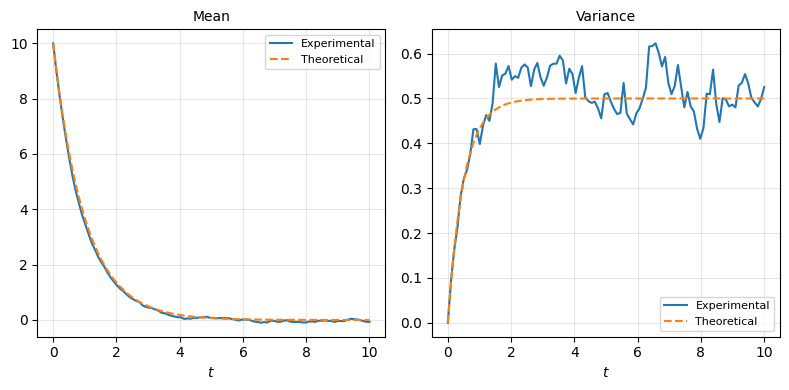

In [4]:
# Plot the mean and variance
xmean = np.mean(x, axis=0)
xvar = np.var(x, axis=0)

xmean_theory = x0 * np.exp(-theta * t) + mu * (1 - np.exp(-theta * t))
xvar_theory = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), layout='tight')
ax1.plot(t, xmean, label='Experimental')
ax1.plot(t, xmean_theory, ls='--', label='Theoretical')
ax1.set_title('Mean', fontsize=10)
ax1.set_xlabel('$t$', fontsize=10)
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2.plot(t, xvar, label='Experimental')
ax2.plot(t, xvar_theory, ls='--', label='Theoretical')
ax2.set_title('Variance', fontsize=10)
ax2.set_xlabel('$t$', fontsize=10)
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.show()
    